In [1]:
from resolve import resolve
resolve()
import pickle 
import numpy as np
from typing import Any
from dataclasses import dataclass as dc, field
import copy
import re
from pprint import pp 
import warnings
import copy
import json

from equilibrator_api import ComponentContribution, Reaction
from vivarium.vivarium import Vivarium
import polars as pl
import pandas as pd
from equilibrator_api.component_contribution import Compound
import pennylane as qml
from matplotlib import pyplot as plt
from pennylane import numpy as np
import scipy
import networkx as nx

from kinetic_rate_laws import KineticFluxModel
from enzyme_kinetics import EnzymeKinetics
from spreadsheets import read_tsv
from genEcoli.interface import OmniProcess, update_inheritance
from simdata import reaction_data, cc
from dispatch import dispatch_simulation

def find_key(d, target_key):
    """Recursively search for the target_key in a nested dictionary."""
    if isinstance(d, dict):
        for key, value in d.items():
            if key == target_key:
                return value
            result = find_key(value, target_key)
            if result is not None:
                return result
    elif isinstance(d, list):
        for item in d:
            result = find_key(item, target_key)
            if result is not None:
                return result
    return None
    
def strip_compartment(tagged_str):
    return re.sub(r'\[.*?\]', '', tagged_str)
    
def get_formula(reaction: dict) -> str:
    reactants = []
    products = []
    rxn_op_mapper = {
        "BOTH": "<=>",
        "L2R": "=>",
        "R2L": "<="
    }
    direction = reaction['direction']
    op = rxn_op_mapper[direction]
    for compound_name, coeff in reaction['stoichiometry'].items():
        n_used = abs(coeff)
        identifier = strip_compartment(compound_name)
        compound_def = f"{n_used}{identifier}" if n_used > 1 else str(identifier)
        if coeff < 0:
            reactants.append(compound_def)
        else:
            products.append(compound_def)
    formula = " + ".join(reactants)
    formula += f" {op} "
    formula += " + ".join(products)
        
    return formula.strip()

def get_stoichiometry(rxn_data):
    """Outputs a dataframe where:
    - rows: Reaction Names
    - cols: Reaction idx
    """
    rxns = []
    for r in rxn_data.all:
        formula = get_formula(r)
        rxns.append(formula)
    return cc.create_stoichiometric_matrix_from_reaction_formulas(rxns).T
    
def nbits(x):
    def array_nbits(x):
        return x.size * x.itemsize * 8
    if isinstance(x, int):
        return x.bit_length()
    if isinstance(x, bytes):
        return len(x) * 8
    if isinstance(x, list):
        x = np.array(x)
        return array_nbits(x)
    if isinstance(x, np.ndarray):
        return array_nbits(x)
    if isinstance(x, str):
        return len(x.encode('utf-8')) * 8
    if isinstance(x, dict):
        serialized = pickle.dumps(x)
        return len(serialized) * 8

def to_binary(obj) -> str:
    return ''.join(f'{byte:08b}' for byte in pickle.dumps(obj))

def from_binary(binary_str: str):
    # Split into 8-bit chunks and convert each to a byte
    byte_chunks = [int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8)]
    byte_data = bytes(byte_chunks)
    return pickle.loads(byte_data)
    
def pad(msg_binary: str) -> str:
    binary_str = msg_binary
    size = len(binary_str)
    key = ''
    for i in range(size):
        key += rand_bit()
    return key

def encrypt(msg: Any, key: str):
    if not isinstance(msg, str):
        msg = to_binary(msg)
        
    zipped = zip_bits(msg, key)
    encrypted = ''
    for a, b in zipped:
        encrypted += str(xor(a, b))
    return encrypted
    
def decrypt(enc: str, key: str):
    zipped = zip_bits(enc, key)
    msg = ''
    for a, b in zipped:
        msg += str(xor(a, b))
    return from_binary(msg)

def xor(a: int, b: int) -> int:
    return 0 if a == b else 1

# noinspection PyTypeChecker
def zip_bits(msg: str, pad: str) -> tuple[int, int]:
    split_msg, split_pad = tuple(list(map(
        lambda arr: [bit for bit in arr],
        [msg, pad]
    )))

    return tuple(zip(split_msg, split_pad))

def rand_bit(thresh: float = 0.3) -> str:
    return str(int(np.random.random() > thresh))

def get_node_pairs(nodes: list) -> list[tuple]:
    from itertools import combinations
    return list(combinations(nodes, 2))
    
def nqubits_basis_encoding(data):
    """Bitwise, thus if data.bitstring = 101, then this returns n qubits as 3"""
    return get_num_bits(data)

def nqubits_amplitude_encoding(data: list | np.ndarray):
    """Encode a vector of 2^n amplitudes, thus if v=[1, 2, 3], then this returns
    np.log2(len(v))
    """
    l = len(data)
    return np.log2(l)

<unknown>:1: SyntaxWarning: invalid escape sequence '\s'


### 1. Load/Prepare/Parse Data:
We draw from the following datasources for parameterization and encoding for our Hamiltonian(s):
- `simData.cPickle`: the output of parameter calculator
- `reaction_data`: a summation of all available metabolic reaction definitions/configs found in `ecoli/reconstruction/ecoli/flat`, read in from corresponding `.tsv` files
- `vivecoli_t2527.json`: (I think) a file containing the WCM output state at `t=2527`.
  
> - TODO: Which processes were used in the composite that generated `vivecoli_t2527.json`? In other words, for which layer is `vivecoli_t2527.json`'s origin? (core? -> antibiotics?, core? -> biomanu.?`).
> - TODO: Ensure that the json file is the most accurate/best version to work with

#### If your phase φ lies in [0,1), and you want to estimate it to n bits of precision, number of qubits needed is:
`nqubits = nEstimationQubits(aka wires) + nUnitaryOperatorQubits`

In [2]:
# TODO: can we use these objects to parameterize estimators?

# a. vEcoli: reconstruction.ecoli.simulation_data.SimulationDataEcoli
simdata_path = '../resources/reconstruction/sim_data/kb/simData.cPickle'
with open(simdata_path, 'rb') as f:
    simdata = pickle.load(f)
internal_state = simdata.internal_state
external_state = simdata.external_state

# b. qEcoli: simdata.MetabolicReactionData
R = reaction_data.compile()
Rdata = reaction_data.all

# c. vEcoli: data/... Particularly using flux data
output_state_path = '../resources/data/vivecoli_t2527.json'
with open(output_state_path, 'r') as f:
    outstate = json.load(f)['agents']['0']
flux_data_keys = ['reaction_fluxes', 'external_exchange_fluxes', "base_reaction_fluxes", "actual_fluxes", "target_fluxes", "target_fluxes_upper", "target_fluxes_lower"]
rxn_fluxdata = find_key(outstate, 'reaction_fluxes')

In [3]:
Rdata[0]

{'id': '1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN',
 'stoichiometry': {'ACYL-SN-GLYCEROL-3P[CCO-CYTOSOL]': -1,
  'ACYL-ACP[CCO-CYTOSOL]': -1,
  'L-PHOSPHATIDATE[CCO-CYTOSOL]': 1,
  'ACP[CCO-CYTOSOL]': 1},
 'direction': 'L2R',
 'catalyzed_by': ['1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER']}

In [4]:
len(rxn_fluxdata), len(find_key(outstate, 'actual_fluxes'))

(9356, 415)

In [5]:
# for each state object/store s_G in the composite state/stoichiometry G, we can allot a nwires_s_G base on its nbits where:
# nwires_s scales with nbits_s:

import pennylane as qml

# TODO: should this be for the state or over reactions?

def construct_store_registers(data: dict):
    return qml.registers({
        "alice": 1, "bob": 2, "charlie": 3
    })
    print(register)

### TODO: This will be our QPE workflow, do it!:
Given:
- `G`: WCM composite/system state
- `S_G`: stoichiometric matrix of size `(m, R)` where:
  - `m`: num metabolites involved in system `G` reactions
  - `R`: num reactions that occur in system `G`

#### 1. Calculate dgprime for each reaction `r` in `R`:
```python
dg_prime_G: list[dict] = []
for r in rxndata.all:
   rxn = cc.parse_reaction_formula(r.formula)
   dg_r = cc.dg_prime(rxn)
   dg_prime_G.append({r.id: dg_r})
```
#### 2. For a matrix `M_prime` of size `(dgR, m, R, kP)`, allocate num wires and construct wire registers across matrix (interpolate?)
#### 3. Map wire registers and problem to existing (hopefully) Ising Hamiltonian:
```python
[dataset] = qml.data.load(
    "qspin", sysname="Ising", periodicity="open", lattice="chain", layout="1x4"
)
```
#### 4. Define QPE circuit parameterized by the initial dataset state and our wires:
```python
dev = qml.device("lightning.qubit", wires=14)

@qml.qnode(dev)
def circuit():
    # Initialize state register to initial state
    qml.StatePrep(initial_state, wires=register["state"])

    # Apply Hadamard gate to all wires in estimation register
    for wire in register["estimation"]:
        qml.Hadamard(wires=wire)

    qml.ControlledSequence(
        qml.Qubitization(H, register["prep"]),
        control=register["estimation"],
    )

    qml.adjoint(qml.QFT)(wires=register["estimation"])

    return qml.probs(wires=register["estimation"])
```
#### 5. Assign energy fingerprint to `G` (something like):
```python
output = circuit()
lamb = sum([abs(c) for c in H.terms()[0]])
print("Eigenvalue: ", lamb * np.cos(2 * np.pi * (np.argmax(output)) / 2 ** len(register["estimation"])))
```


In [6]:
# TODO: for each reaction in S_G in WCM system G:
# 1. dg_r = Calculate deltaG_r
# 2. wires = interpolate(dg,  

In [7]:
import requests
import json
import xmltodict

s = requests.Session()

with open('../resources/biocyc_credentials.json','r') as f:
    credentials = json.load(f)

s.post('https://websvc.biocyc.org/credentials/login/',
       data={'email': credentials['email'], 'password': credentials['password']})

<Response [200]>

In [8]:
from equilibrator_api import ComponentContribution, Q_, Reaction
cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

In [9]:
def extract_reactions(Rdata, cc, s):
    rxns_names = ['6PFRUCTPHOS-RXN', 'F16ALDOLASE-RXN', '2TRANSKETO-RXN', 'TRIOSEPISOMERIZATION-RXN']
    # TODO: why does this work for the above reactions, but not for all?
    # rxns_names = [data['id'] for data in Rdata]
    rxns_dict = {}
    stoich_dict = {}
    regulation_dict = {}
    
    for name in rxns_names:
        r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
        rxn = xmltodict.parse(r.content)['ptools-xml']
        rxn_dict = {}
        stoich_loop_dict = {}
        regulation_loop_dict = {}
        left = rxn['Reaction']['left']
        right = rxn['Reaction']['right'] 
        
        # i will know exact complex in model (connected to rxn), but for now will pick random
        enz_rxn = rxn['Reaction']['enzymatic-reaction']['Enzymatic-Reaction']
        if type(left) is dict:
            left = [left]
        if type(right) is dict:
            right = [right] 
        if type(enz_rxn) is dict:
            enz_rxn = [enz_rxn]
            
        enz_rxn_id =  enz_rxn[0]['@frameid']
        re = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{enz_rxn_id}&detail=high&fmt=json')
        oe = xmltodict.parse(re.content)['ptools-xml']['Enzymatic-Reaction']['regulated-by']['Regulation']
        if type(oe) is dict:
            oe = [oe]
        # add regulators, target regulator directly with id to get info like irreversible, etc
        for regulator in oe:
            reg_name = regulator['regulator']['Compound']['@frameid']
            reg_type = regulator['mode']['#text']
            reg_type = 1 if reg_type == '+' else -1
            regulation_loop_dict[reg_name] = reg_type
            
        for mol in left:
            if type(mol) is dict:
                cid = mol['Compound']['@frameid']
                mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
                rxn_dict[mol_cc] = -1
                stoich_loop_dict[cid] = -1
        for mol in right:
            if type(mol) is dict:
                cid = mol['Compound']['@frameid']
                mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
                rxn_dict[mol_cc] =  1
                stoich_loop_dict[cid] = 1
        rxns_dict[name] = Reaction(rxn_dict)
        stoich_dict[name] = stoich_loop_dict
        regulation_dict[name] = regulation_loop_dict
        
    return rxns_dict, stoich_dict, regulation_dict
    

def estimate_gibbs(rxns_dict: dict, cc):
    (standard_dg_prime, dg_uncertainty) = cc.standard_dg_prime_multi(list(rxns_dict.values()), uncertainty_representation="cov")
    return (standard_dg_prime, dg_uncertainty)


def format_estimation(rxns, dgPrime, dgUncertainty):
    dg_struct = {
        rname: {"dg_prime": 0, "uncertainty": 0} for rname in rxns
    }
    dg_data = dict(zip(rxns.keys(), dgPrime))
    uncertainty_data = dict(zip(rxns.keys(), dgUncertainty))
    for name in dg_struct:
        dg_struct[name]["dg_prime"] = dg_data[name]
        dg_struct[name]["uncertainty"] = uncertainty_data[name]
    return dg_struct


def get_gibbs(Rdata: list[dict], cc: ComponentContribution, s: requests.Session):
    rxns, stoich, regulation = extract_reactions(Rdata, cc, s)
    dgPrime, dgUncertainty = estimate_gibbs(rxns, cc)
    return format_estimation(rxns, dgPrime, dgUncertainty)

In [10]:
rxns, stoich, regulation = extract_reactions(Rdata, cc, s)
dgPrime, dgUncertainty = estimate_gibbs(rxns, cc)

In [11]:
import math

def get_factorization_wires(n: int):
    """
    Given a number n, returns:
    - wires_m: list of wire indices for factor m
    - wires_k: list of wire indices for factor k
    - wires_solution: list of wire indices for m * k
    """
    # Bit length of the product m * k
    bits_solution = math.ceil(math.log2(n))
    
    # Upper bound for m and k is roughly sqrt(n)
    max_factor = math.isqrt(n)
    bits_factor = math.ceil(math.log2(max_factor))
    
    # Assign qubits (wires) sequentially
    wires_m = list(range(bits_factor))
    wires_k = list(range(bits_factor, 2 * bits_factor))
    wires_solution = list(range(2 * bits_factor, 2 * bits_factor + bits_solution))
    
    return wires_m, wires_k, wires_solution


### Performing max-cut with QAOA on a reaction-reaction graph:

In [9]:
# prepare the graph/state
import networkx as nx

def map_metabolites_to_reactions(Rdata: list[dict]):
    from collections import defaultdict
    
    metabolite_to_reactions = defaultdict(set)
    for rxn in Rdata:
        rxn_id = rxn['id']
        stoich = rxn['stoichiometry']
        for met in stoich.keys():
            metabolite_to_reactions[met].add(rxn_id)
    return metabolite_to_reactions


def construct_edges(metabolites_to_reactions) -> set:
    edges = set()
    for reactions in metabolites_to_reactions.values():
        rxn_list = list(reactions)
        for i in range(len(rxn_list)):
            for j in range(i + 1, len(rxn_list)):
                edges.add((rxn_list[i], rxn_list[j]))
    return edges


def construct_graph(mapping, edges):
    import networkx as nx
    G = nx.Graph()
    nodes = list(mapping.keys())
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

def normalize(lst: list[float | int], new_min: int = -1, new_max: int = 1):
    old_min = min(lst)
    old_max = max(lst)
    return [new_min + (x - old_min) * (new_max - new_min) / (old_max - old_min) for x in lst]

data = Rdata[:111]
mapping = map_metabolites_to_reactions(data)
edges = construct_edges(mapping)
G = construct_graph(mapping, edges)

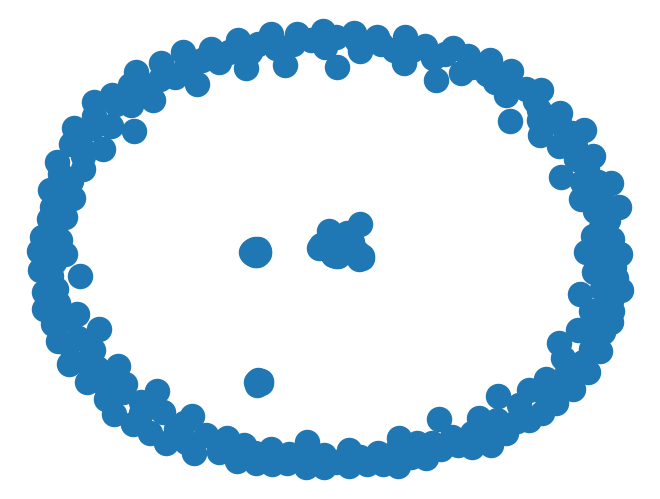

In [10]:
%matplotlib inline 
nx.draw(G, with_labels=False)
plt.show()

In [12]:
# get weights and biasies (higher num shared metabolites ~ higher weight : even bias)

def shared_metabolites(u: str, v: str, mapping):
    # this func should return a list of metabolites that are shared between reaction u and reaction v
    shared = []
    for metabolite_name, reactions_set in mapping.items():
        if u in reactions_set and v in reactions_set:
            shared.append(metabolite_name)
        # else:
        #     shared.append(0)
    return len(shared)

def get_weights(G, mapping):
    raw = [shared_metabolites(u, v, mapping) for u, v in G.edges]
    # raw = [-len(shared_metabolites(u, v, mapping)) for u, v in G.edges]
    # return normalize(raw)
    return normalize(raw)

def get_bias(G, default: int = 0):
    return [default for _ in G.nodes]
    
weights = get_weights(G, mapping)
bias = get_bias(G)

In [13]:
# qaoa/pennylane setup

import pennylane as qml
from matplotlib import pyplot as plt
from pennylane import numpy as np
import scipy
import networkx as nx
import copy

np.random.seed(42)
qubit_number = len(G.nodes)
qubits = range(qubit_number)

n_wires = qubit_number

# Your reaction node labels
reaction_nodes = list(G.nodes)

# Map reaction labels to integers and relable nodes
reaction_to_wire = {reaction: i for i, reaction in enumerate(reaction_nodes)}
wire_to_reaction = {i: reaction for reaction, i in reaction_to_wire.items()}  # optional reverse map
G_mapped = nx.relabel_nodes(G, reaction_to_wire)
graph = G_mapped.edges

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)

# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        qml.CNOT(wires=edge)
        qml.RZ(gamma, wires=edge[1])
        qml.CNOT(wires=edge)
        # Could also do
        # IsingZZ(gamma, wires=edge)

def bitstring_to_int(bit_string_sample):
    return int(2 ** np.arange(len(bit_string_sample)) @ bit_string_sample[::-1])

In [20]:
dev = qml.device("lightning.qubit", wires=n_wires, shots=20)
register = qml.registers({nodename: 1 for nodename in G_mapped.nodes})

In [21]:
@qml.qnode(dev)
def circuit(gammas, betas, return_samples=False, **kwargs):
    # apply Hadamards to get the n qubit |+> state
    for name, wire in register.items():
        qml.Hadamard(wires=wire)
    # for wire in range(n_wires):
    #     qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for gamma, beta in zip(gammas, betas):
        U_C(gamma)
        U_B(beta)

    if return_samples:
        # sample bitstrings to obtain cuts
        return qml.sample()
    # during the optimization phase we are evaluating the objective using expval
    C = qml.sum(*(qml.Z(w1) @ qml.Z(w2) for w1, w2 in graph))
    return qml.expval(C)


def objective(params):
    """Minimize the negative of the objective function C by postprocessing the QNnode output."""
    return -0.5 * (len(graph) - circuit(*params))

In [22]:
import time

n_layers = 1
init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

def qaoa_maxcut(n_layers=1):
    print(f"\np={n_layers:d}")

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params.copy()
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print(f"Objective after step {i+1:3d}: {-objective(params): .7f}")

    # sample 100 bitstrings by setting return_samples=True and the QNode shot count to 100
    bitstrings = circuit(*params, return_samples=True, shots=100)
    # convert the samples bitstrings to integers
    sampled_ints = [bitstring_to_int(string) for string in bitstrings]
    
    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(sampled_ints))
    most_freq_bit_string = np.argmax(counts)
    print(f"Optimized parameter vectors:\ngamma: {params[0]}\nbeta:  {params[1]}")
    print(f"Most frequently sampled bit string is: {most_freq_bit_string:04b}")

    return -objective(params), sampled_ints


# perform QAOA on our graph with p=1,2 and keep the lists of sampled integers
int_samples1 = qaoa_maxcut(n_layers=1)[1]
int_samples2 = qaoa_maxcut(n_layers=2)[1]


p=1


ValueError: vector

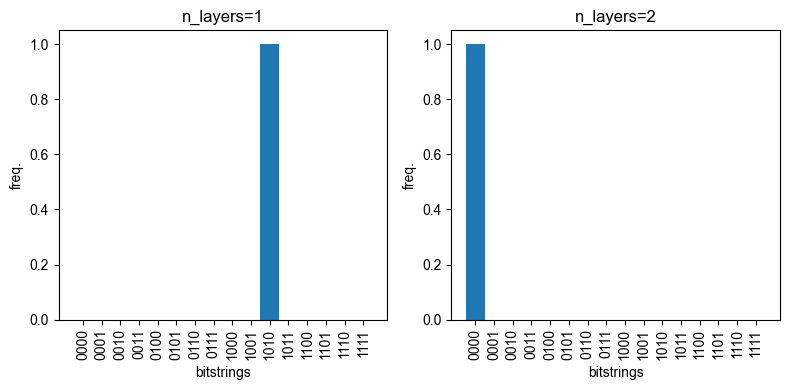

In [20]:
# post-processing/analysis

import matplotlib.pyplot as plt
%matplotlib inline
xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, _ = plt.subplots(1, 2, figsize=(8, 4))
for i, samples in enumerate([int_samples1, int_samples2], start=1):
    plt.subplot(1, 2, i)
    plt.title(f"n_layers={i}")
    plt.xlabel("bitstrings")
    plt.ylabel("freq.")
    plt.xticks(xticks, xtick_labels, rotation="vertical")
    plt.hist(samples, bins=bins)
plt.tight_layout()
plt.show()

In [35]:
# post-processing/packaging
from collections import Counter

# ...assuming int_samples1 is a list of integers from the measurement
bitstrings = list(map(lambda x: format(x, "04b"), int_samples1))  # length-4 binary strings
most_common_bitstring = Counter(bitstrings).most_common(1)[0][0]
print("Most frequent bitstring (best cut):", most_common_bitstring)

def get_cuts(most_common_bitstring, G) -> dict[str, list[str]]:
    # get cuts by reaction indices
    cut_A = [i for i, bit in enumerate(most_common_bitstring) if bit == '0']
    cut_B = [i for i, bit in enumerate(most_common_bitstring) if bit == '1']
    print("Set A:", cut_A)
    print("Set B:", cut_B)

    # get cuts by reaction name
    edgenames = []
    for a, b in set(G.edges):
        edgenames.append(a)
        edgenames.append(b)
    edgenames = list(set(edgenames))
    reaction_to_wire = dict(zip(
        edgenames,
        list(range(len(edgenames)))
    ))
    wire_to_reaction = {v: k for k, v in reaction_to_wire.items()}
    set_0 = [wire_to_reaction[i] for i in cut_A]
    set_1 = [wire_to_reaction[i] for i in cut_B]
    print("Cut A(0) (reactions):", set_0)
    print("Cut B(1) (reactions):", set_1)
    return {"0": set_0, "1": set_1}

cuts = get_cuts(most_common_bitstring, G)
cuts['0']

Most frequent bitstring (best cut): 1110101
Set A: [3, 5]
Set B: [0, 1, 2, 4, 6]
Cut A(0) (reactions): ['1.1.1.215-RXN', '1.1.1.83-RXN']
Cut B(1) (reactions): ['1.1.1.39-RXN', '1.1.1.127-RXN', '1.1.1.271-RXN', '1.1.1.283-RXN', '1.13.11.16-RXN']


['1.1.1.215-RXN', '1.1.1.83-RXN']

In [46]:
node_partition = {
    cut: 0
    for cut in cuts['0'] + cuts['1']
}

for cut in node_partition:
    if cut in cuts['1']:
        node_partition[cut] = 1


# colors = [node_partition[node] for node in G.nodes()]
colors = list(node_partition.values())

In [50]:
len(colors)

7

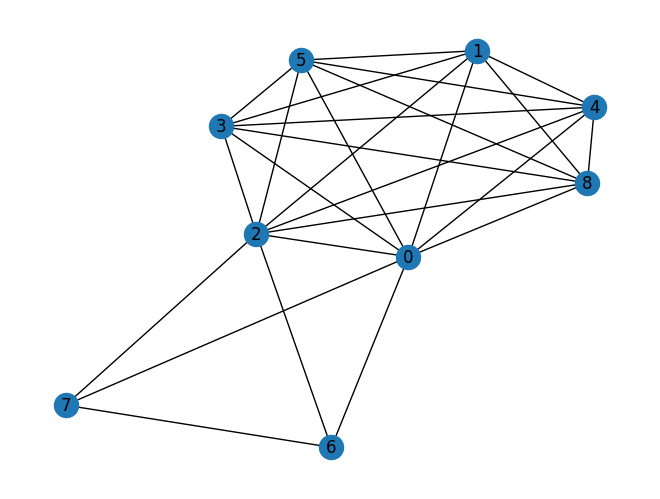

In [49]:
nx.draw(G_mapped, with_labels=True) # node_color=colors, cmap=plt.cm.coolwarm, with_labels=True)

plt.show()

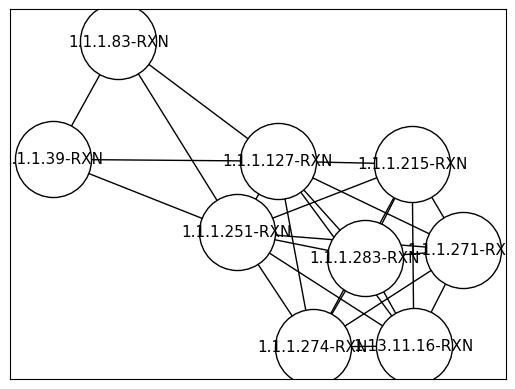

In [31]:
pos = nx.spring_layout(G, seed=1)
options = {
    "font_size": 11,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    # "linewidths": 1,
    # "width": 5,
}
nx.draw_networkx(G, pos, **options)
plt.show()

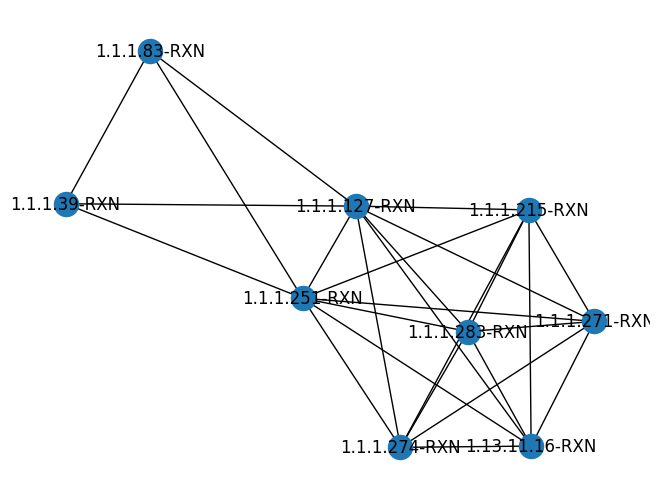

In [32]:
nx.draw(G, with_labels=True, pos=pos)
plt.show()